# Adaptive Systeme - Hausaufgabe 2
Henry Fock

## Aufbau und Formeln für ein neuronales Netz
Ein neuronales Netz ist aus mehreren Komponenten aufgebaut:
- Vollvernetzte (lineare) Schicht. Dies entspricht dem Matrix - Vektorprodukt von Gewichtematrix und Eingabevektor. Die Zeilen der Gewichtematrix entsprechen den Gewichten der Eingangsneuronen (Spaltenvektor): $$f(x) = W^Tx$$
- (Nicht lineare) Aktivierungs-/ Transferfunktion. Hier wird die Fermi-/ Sigmoidfunktion verwendet: $$\sigma(x) = \frac{1}{1 + \exp(-x)}$$
- Fehlerfunktion. Hier wird zum einen die Categorical Cross Entropy und der Mean Squered Error verwendet. Dabei ist $x$ das Ergebnis des Netzes und $y$ der Zielwert. $x$ und $y$ sind jeweils Spaltenvektoren.
\begin{align*}
\text{MSE}(x,y) &= \frac{1}{|x|}\sum_{i=0}^{|x|} \left(x_i - y_i \right)^2 \\
\text{CCE}(x,y) &= -\sum_{i=0}^{|x|} y_i \cdot \log(x_i)
\end{align*}

Ein Forward-pass, bis zum Fehler $E$ über eine Schicht entspricht:
$$E\left(\sigma\left(f\left(x\right)\right)\right)$$
Über zwei Schichten:
$$E\left(\sigma_2\left(f_2\left(\sigma_1\left(f_1\left(x\right)\right)\right)\right)\right)$$

### Formeln für Backpropegation
Außerdem werden die partiellen Ableitungen für das Gradientenabstiegsverfahren der einzelnen Funktionen benötigt. Die lineare Schicht benötigt eine mit Bezug auf die Gewichte, um diese zu ändern und eine mit Bezug auf den Eingang, um den Gradienten in die darüberliegenden Schichten weiterzuleiten.
Die Gradienten lassen sich über die Kettenregel berechnen:

\begin{align*}
\frac{\partial E}{\partial w_{ij}^2} &= \frac{\partial f_2}{\partial w_{ij}^2} \cdot \frac{\partial \sigma_2}{\partial f_2} \cdot \frac{\partial E}{\partial \sigma_2}  \\
\delta_2 &= \frac{\partial \sigma_2}{\partial f_2} \cdot \frac{\partial E}{\partial \sigma_2} \\
\frac{\partial E}{\partial w_{ij}^1} &= \frac{\partial f_1}{\partial w_{ij}^1}\cdot \frac{\partial \sigma_1}{\partial f_1} \cdot \frac{\partial f_2}{\partial \sigma_1} \cdot \delta_2 
\end{align*}

Die Formeln für die Gradienten sind:
\begin{align*}
\frac{\partial f}{\partial w_{ij}} &= x_i \\
\frac{\partial f_2}{\partial \sigma_1} &= W \\
\frac{\partial \sigma}{\partial f} &= \sigma(f)\cdot (1 - \sigma(f)) \\
\frac{\partial \text{MSE}}{\partial \sigma_i} &= \frac{1}{|\sigma|}\cdot 2(\sigma_i - y_i) \\
\frac{\partial \text{CCE}}{\partial \sigma_i} &= -\frac{y}{\sigma_i}
\end{align*}


## Implementierung: Definieren von abstrakten Oberklassen für Schichten Fehler und Modelle

In [1]:
from typing import *
from abc import ABC, abstractmethod
import numpy as np


class Layer(ABC):
    @abstractmethod
    def forward(self, x: np.ndarray, train: bool = False) -> np.ndarray:
        raise NotImplementedError()

    @abstractmethod
    def backwards(self, prev_grads: np.ndarray) -> np.ndarray:
        raise NotImplementedError()

    @abstractmethod
    def train(self, lr: float = 0.01) -> None:
        raise NotImplementedError()


class Loss(ABC):
    @abstractmethod
    def loss(self, x: np.ndarray, y: np.ndarray, train: bool = False) -> float:
        raise NotImplementedError()

    @abstractmethod
    def backwards(self) -> np.ndarray:
        raise NotImplementedError()


class Model(ABC):
    @abstractmethod
    def predict(self, x: np.ndarray) -> np.ndarray:
        raise NotImplementedError()

    @abstractmethod
    def train(
        self,
        x: np.ndarray,
        y: np.ndarray,
        epochs: int = 10,
        lr: float = 0.01,
        batch_size: int = 1,
        loss_threshold: float = 1e-2,
        shuffle: bool = True,
    ) -> None:
        raise NotImplementedError()


## Implementierung: Implementieren der Layer

In [2]:
class Linear(Layer):
    def __init__(self, num_inputs: int, num_outputs: int, weight_init:str = "uniform") -> None:
        assert weight_init in ("uniform", "normal")

        self.num_inputs = num_inputs
        self.num_inputs = num_outputs

        if weight_init == "uniform":
            self.weights = np.random.rand(num_inputs + 1, num_outputs)
        if weight_init == "normal":
            self.weights = np.random.randn(num_inputs + 1, num_outputs)
        
        # self.weights *= np.sqrt(1.0 / num_inputs)

        self.weight_gradients: np.ndarray = None

        self.train_input: np.ndarray = None
        self.train_output: np.ndarray = None

    def forward(self, x: np.ndarray, train: bool = False) -> np.ndarray:
        x_bias = np.vstack([np.ones((1, 1)), x])
        out = np.dot(self.weights.T, x_bias)
        if train:
            self.train_input = x_bias
            self.train_output = out
        return out

    def backwards(self, prev_grads: np.ndarray) -> np.ndarray:
        self.weight_gradients = np.dot(prev_grads, self.train_input.T).T
        return np.dot(self.weights[1:], prev_grads)

    def train(self, lr: float = 0.01) -> None:
        self.weights -= lr * self.weight_gradients
        self.weight_gradients = None
        self.train_input = None
        self.train_output = None


class Sigmoid(Layer):
    def __init__(self) -> None:
        self.train_input: np.ndarray = None
        self.train_output: np.ndarray = None

    def forward(self, x: np.ndarray, train: bool = False) -> np.ndarray:
        out = 1 / (1 + np.exp(-x))
        if train:
            self.train_input = x
            self.train_output = out
        return out

    def backwards(self, prev_grads: np.ndarray) -> np.ndarray:
        grads = self.train_output * (1 - self.train_output)
        return prev_grads * grads

    def train(self, *_) -> None:
        self.train_input = None
        self.train_output = None



class LeakyReLu(Layer):
    def __init__(self, leak:float = 0.2) -> None:
        self.train_input: np.ndarray = None
        self.train_output: np.ndarray = None
        self.leak:float = leak
    
    def forward(self, x: np.ndarray, train: bool = False) -> np.ndarray:
        out = x.copy()
        out[out < 0] *= self.leak
        if train:
            self.train_input = x
            self.train_output = out
        return out

    def backwards(self, prev_grads: np.ndarray) -> np.ndarray:
        grads = np.ones_like(self.train_input)
        grads[self.train_output == 0] = self.leak
        return prev_grads * grads

    def train(self, *_) -> None:
        self.train_input = None
        self.train_output = None


class Tanh(Layer):
    def __init__(self) -> None:
        self.train_input: np.ndarray = None
        self.train_output: np.ndarray = None
    
    def forward(self, x: np.ndarray, train: bool = False) -> np.ndarray:
        out = np.tanh(x)
        if train:
            self.train_input = x
            self.train_output = out
        return out

    def backwards(self, prev_grads: np.ndarray) -> np.ndarray:
        grads = 1 - np.power(self.train_output, 2)
        return prev_grads * grads

    def train(self, *_) -> None:
        self.train_input = None
        self.train_output = None

## Implementierung: Implementieren der Fehlerfunktionen

In [84]:
class MeanSquereError(Loss):
    def __init__(self) -> None:
        self.train_x: np.ndarray = 0
        self.train_y: np.ndarray = 0

    def loss(self, x: np.ndarray, y: np.ndarray, train: bool = False) -> float:
        if train:
            self.train_x = x
            self.train_y = y
        return np.mean(np.power(x - y, 2))

    def backwards(self) -> np.ndarray:
        out = 2/self.train_y.size*(self.train_x - self.train_y)
        return out

class CategoricalCrossEntropy(Loss):
    def __init__(self) -> None:
        self.train_x: np.ndarray = 0
        self.train_y: np.ndarray = 0

    def loss(self, x: np.ndarray, y: np.ndarray, train: bool = False) -> float:
        if train:
            self.train_x = x
            self.train_y = y
        return -np.sum(y * np.log(x))

    def backwards(self) -> np.ndarray:
        out = -(self.train_y / self.train_x)
        return out


class BinaryCrossEntropy(Loss):
    def __init__(self) -> None:
        self.train_x: np.ndarray = 0
        self.train_y: np.ndarray = 0

    def loss(self, x: np.ndarray, y: np.ndarray, train: bool = False) -> float:
        if train:
            self.train_x = x
            self.train_y = y
        return (1/y.size) * np.sum(-(y * np.log(x) + (1-y) * np.log(1-x)))

    def backwards(self) -> np.ndarray:
        out = (1/self.train_y.size) * ((self.train_x - self.train_y) / ((1 - self.train_x) * self.train_x))
        return out



## Implementierung: Trainingsroutine im MultilayerPerceptron

### Helferklasse fürs Datenhandling

In [5]:
class Dataset:
    @classmethod
    def shuffle(self, x: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray]:
        sampling = np.random.permutation(x.shape[0])
        return x[sampling], y[sampling]

In [112]:
class MultiLayerPerceptron:
    def __init__(self, layers: List[Layer], loss: Loss) -> None:
        self.layers = layers
        self.loss_function = loss

    def predict(self, x: np.ndarray) -> np.ndarray:
        results = np.array([self._forward(sample, train=False) for sample in x])
        return results

    def _forward(self, x: np.ndarray, train: bool) -> np.ndarray:
        intermed_result: np.ndarray = x
        for layer in self.layers:
            intermed_result = layer.forward(intermed_result, train=train)
        return intermed_result

    def _backpropegate(self) -> None:
        gradient = self.loss_function.backwards()
        for layer in self.layers[::-1]:
            gradient = layer.backwards(gradient)

    def _update_weights(self, lr: float = 0.01) -> None:
        for layer in self.layers[::-1]:
            layer.train(lr)

    def train(
        self,
        x: np.ndarray,
        y: np.ndarray,
        epochs: int = 10,
        lr: float = 0.01,
        min_delta: float = 1e-5,
        loss_threshold:float = 1e-2,
        shuffle: bool = True
    ):
        epoch: int = 1
        last_loss = 1e5
        while epoch <= epochs:
            xs, ys = x, y
            if shuffle:
                xs, ys = Dataset.shuffle(x, y)
            for sample_x, sample_y in zip(xs, ys):
                result = self._forward(sample_x, train=True)
                self.loss_function.loss(result, sample_y, train=True)

                self._backpropegate()
                self._update_weights(lr)


            intermed_preds = self.predict(x)
            intermed_loss = self.loss_function.loss(intermed_preds, y)


            if loss_threshold > intermed_loss:
                print(f"Fehlergrenze unterschritten nach {epoch} Epochen!")
                return

            if min_delta > 0:
                loss_delta = abs(last_loss - intermed_loss)
                last_loss = intermed_loss

                if loss_delta < min_delta:
                    print(f"Konvergenz nach {epoch} Epochen!")
                    return

            epoch += 1

        print(f"Abbruch nach {epoch-1} Epochen!")

## Erstellen von Helferklassen zur Datenrepräsentation
Zuordnung der Segmente mit ihren Indizes:

<img src="Images/d8.png" alt="drawing" width="200"/>

In [62]:
import matplotlib.pyplot as plt


class SevenSegment:
	def __init__(self, encoding: np.ndarray) -> None:
		assert encoding.size == 7
		self.encoding = encoding

	def display(self) -> None:
		segments = self.getEncoding()
		assert segments.size == 7

		image = np.zeros((5, 3), dtype=np.uint8)
		segment_to_image = {
			0: {"x":[0, 0, 0], "y":[0, 1, 2]},
			1: {"x":[0, 1, 2], "y":[0, 0, 0]},
			2: {"x":[0, 1, 2], "y":[2, 2, 2]},
			3: {"x":[2, 2, 2], "y":[0, 1, 2]},
			4: {"x":[2, 3, 4], "y":[0, 0, 0]},
			5: {"x":[2, 3, 4], "y":[2, 2, 2]},
			6: {"x":[4, 4, 4], "y":[0, 1, 2]},
		}

		for i, segment in enumerate(segments):
			if segment == 1:
				s2i = segment_to_image[i]
				image[s2i["x"], s2i["y"]] = 1

		plt.imshow(image)
		plt.show()

	def getEncoding(self) -> np.ndarray:
		return self.encoding


def seven_segment_factory_method(char: str) -> SevenSegment:
	assert char in ("0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "A", "b", "C", "d", "E", "F")
	if char == "0":
		return SevenSegment(np.array([1, 1, 1, 0, 1, 1, 1]))
	if char == "1":
		return SevenSegment(np.array([0, 1, 0, 0, 1, 0, 0]))
	if char == "2":
		return SevenSegment(np.array([1, 0, 1, 1, 1, 0, 1]))
	if char == "3":
		return SevenSegment(np.array([1, 0, 1, 1, 0, 1, 1]))
	if char == "4":
		return SevenSegment(np.array([0, 1, 1, 1, 0, 1, 0]))
	if char == "5":
		return SevenSegment(np.array([1, 1, 0, 1, 0, 1, 1]))
	if char == "6":
		return SevenSegment(np.array([0, 1, 0, 1, 1, 1, 1]))
	if char == "7":
		return SevenSegment(np.array([1, 0, 1, 0, 0, 1, 0]))
	if char == "8":
		return SevenSegment(np.array([1, 1, 1, 1, 1, 1, 1]))
	if char == "9":
		return SevenSegment(np.array([1, 1, 1, 1, 0, 1, 0]))
	if char == "A":
		return SevenSegment(np.array([1, 1, 1, 1, 1, 1, 0]))
	if char == "b":
		return SevenSegment(np.array([0, 1, 0, 1, 1, 1, 1]))
	if char == "C":
		return SevenSegment(np.array([1, 1, 0, 0, 1, 0, 1]))
	if char == "d":
		return SevenSegment(np.array([0, 0, 1, 1, 1, 1, 1]))
	if char == "E":
		return SevenSegment(np.array([1, 1, 0, 1, 1, 0, 1]))
	if char == "F":
		return SevenSegment(np.array([1, 1, 0, 1, 1, 0, 0]))


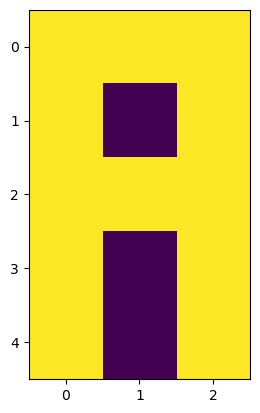

In [64]:
seven_segment_factory_method("A").display()

# Aufgabe 1
Untersuchen Sie wie die Lernf¨ahigkeit und -geschwindigkeit des Netz von

- der Anzahl der zu erlernenden Muster d.h. 0 – 9 oder 0 – 15...
- der Anzahl der Eingabeneuronen, also entweder 4 oder 10/16...
- der Anzahl der verborgenen Neuronen Schichten...
- der Anzahl der Neuronen in der jeweiligen Schicht...

...abhängt

## Erzeugen des Trainingsdatensatzes

In [65]:
chars = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "A", "b", "C", "d", "E", "F"]
seven_segments = [seven_segment_factory_method(x) for x in chars]
x = np.expand_dims(np.identity(len(chars)), -1)
y = np.expand_dims(np.array([x.getEncoding() for x in seven_segments]), -1)

## Erzeugen des Netzwerkes und anstoßen des Trainings

In [113]:
np.random.seed(0)

# network: List[Layer] = [Linear(len(x), 7, "normal"), Sigmoid()]
network: List[Layer] = [Linear(len(x), len(x), "normal"), Sigmoid(), Linear(len(x), 7), Sigmoid()]
loss = MeanSquereError()

mlp = MultiLayerPerceptron(network, loss)
mlp.train(x, y, epochs=5000, lr=0.5, min_delta=1e-5, loss_threshold=1e-2)
pred = mlp.predict(x)
print("Fehler: ", loss.loss(pred, y))

Fehlergrenze unterschritten nach 348 Epochen!
Fehler:  0.009974545480869115


In [114]:
networks: dict[list[Layer]] = {
	"0 hidden":							[Linear(len(x), 7), Sigmoid()],
	f"1 hidden mit {len(x)} Neuronen":	[Linear(len(x), len(x)), Sigmoid(), Linear(len(x), 7), Sigmoid()],
	"1 hidden mit 7 Neuronen": 			[Linear(len(x), 7), Sigmoid(), Linear(7, 7), Sigmoid()],
	"1 hidden mit 4 Neuronen": 			[Linear(len(x), 4), Sigmoid(), Linear(4, 7), Sigmoid()],
	"1 hidden mit 2 Neuronen": 			[Linear(len(x), 2), Sigmoid(), Linear(2, 7), Sigmoid()],
	f"2 hidden mit {len(x)}/{len(x)} Neuronen": [Linear(len(x), len(x)), Sigmoid(), Linear(len(x), len(x)), Sigmoid(), Linear(len(x), 7), Sigmoid()],
	"2 hidden mit 7/7 Neuronen": [Linear(len(x), 7), Sigmoid(), Linear(7, 7), Sigmoid(), Linear(7, 7), Sigmoid()],
	"2 hidden mit 4/4 Neuronen": [Linear(len(x), 4), Sigmoid(), Linear(4, 4), Sigmoid(), Linear(4, 7), Sigmoid()],
	"2 hidden mit 2/2 Neuronen": [Linear(len(x), 2), Sigmoid(), Linear(2, 2), Sigmoid(), Linear(2, 7), Sigmoid()],
}

for description, network in networks.items():
	print("Netzwerkkonfiguration: ", description)

	np.random.seed(0)

	loss = MeanSquereError()
	mlp = MultiLayerPerceptron(network, loss)
	mlp.train(x, y, epochs=1000, lr=0.5, min_delta=1e-5, loss_threshold=1e-2)
	pred = mlp.predict(x)
	print("Fehler: ", loss.loss(pred, y))
	print("------------")
	print("")

Netzwerkkonfiguration:  0 hidden
Fehlergrenze unterschritten nach 444 Epochen!
Fehler:  0.009996968770542083
------------

Netzwerkkonfiguration:  1 hidden mit 16 Neuronen
Fehlergrenze unterschritten nach 430 Epochen!
Fehler:  0.009970121956560036
------------

Netzwerkkonfiguration:  1 hidden mit 7 Neuronen
Fehlergrenze unterschritten nach 487 Epochen!
Fehler:  0.009992691714824361
------------

Netzwerkkonfiguration:  1 hidden mit 4 Neuronen
Abbruch nach 1000 Epochen!
Fehler:  0.029940036306122183
------------

Netzwerkkonfiguration:  1 hidden mit 2 Neuronen
Abbruch nach 1000 Epochen!
Fehler:  0.08787919513370332
------------

Netzwerkkonfiguration:  2 hidden mit 16/16 Neuronen
Konvergenz nach 2 Epochen!
Fehler:  0.3212734396316145
------------

Netzwerkkonfiguration:  2 hidden mit 7/7 Neuronen
Konvergenz nach 39 Epochen!
Fehler:  0.21447507258092063
------------

Netzwerkkonfiguration:  2 hidden mit 4/4 Neuronen
Konvergenz nach 23 Epochen!
Fehler:  0.21437283639019172
------------



## Anzeigen der Ergebnisse

In [91]:
pred = np.round(pred,0)
loss_after_rounding = loss.loss(y, pred)
print(f"Fehler nach Rundung: {loss_after_rounding}")

Fehler nach Rundung: nan


C:\Users\hfock\AppData\Local\Temp\ipykernel_19016\2757090738.py:41: RuntimeWarning: divide by zero encountered in log
  return (1/y.size) * np.sum(-(y * np.log(x) + (1-y) * np.log(1-x)))
C:\Users\hfock\AppData\Local\Temp\ipykernel_19016\2757090738.py:41: RuntimeWarning: invalid value encountered in multiply
  return (1/y.size) * np.sum(-(y * np.log(x) + (1-y) * np.log(1-x)))


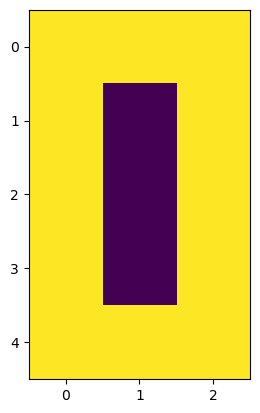

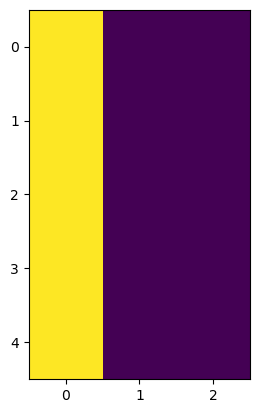

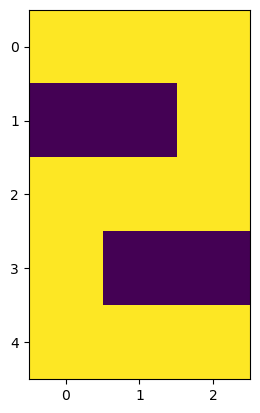

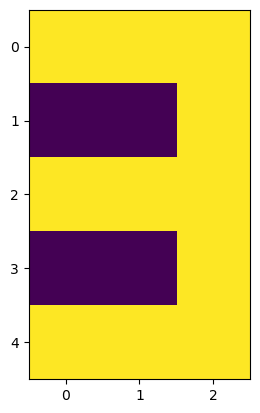

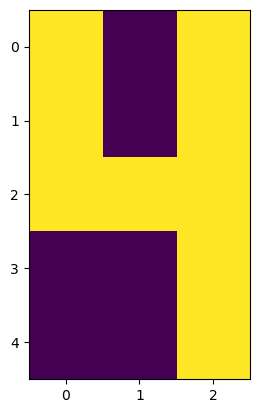

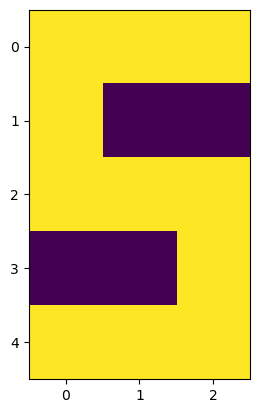

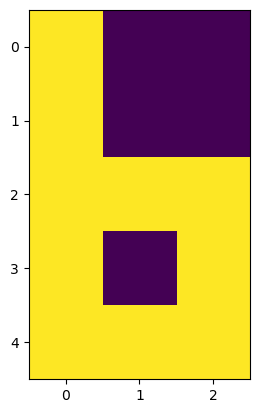

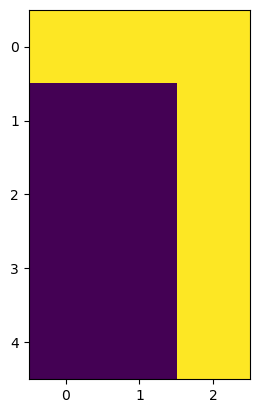

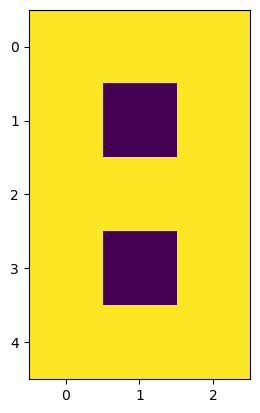

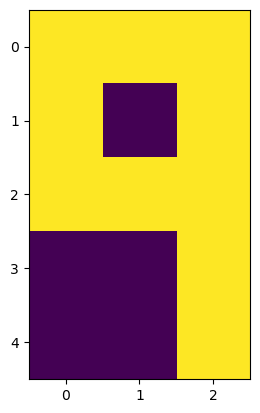

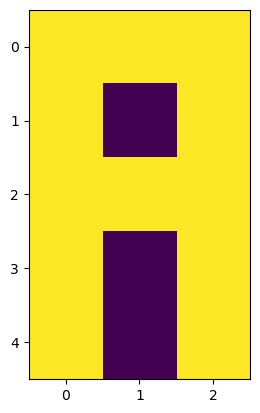

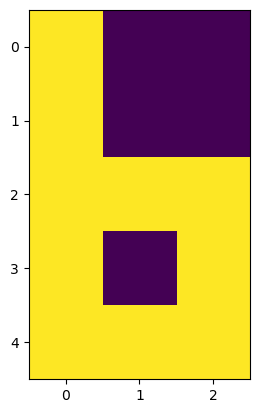

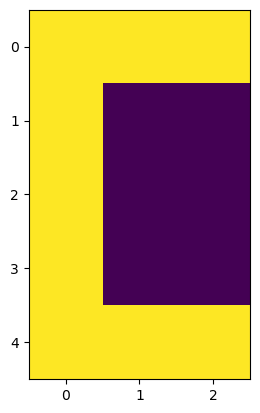

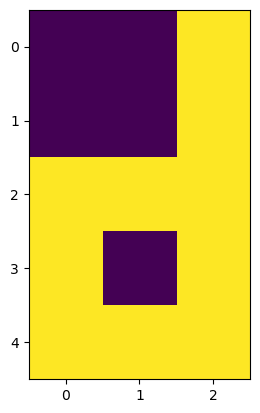

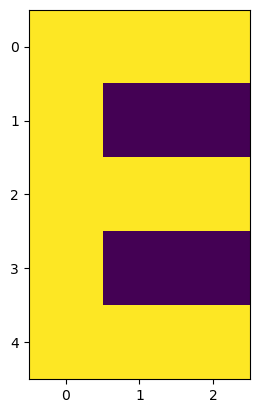

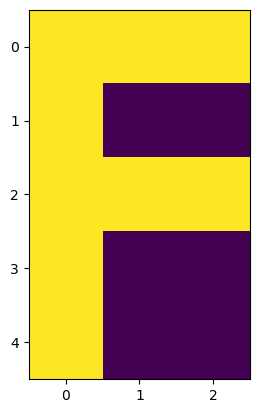

In [92]:
for encoding in pred:
	SevenSegment(encoding).display()